
# Mathematical methods for machine learning
This notebook illustrates how to implement a simple neural network from scratch using the Fashion-MNIST dataset.


Created by Felix Schlatter. 

# Neural Network
To create a neural network some helper functions are firstly defined:
Activation functions are used in the neural network after the calculation of $Z = W^T\cdot x + b $ to add some nonlinearities.

## Activation functions



The activation functions to the output of the neural net (Variable $Z$)
### Sigmoid activation
The sigmoid function 
$$
\begin{equation}
\sigma(Z) = \frac{1}{1+e^{-Z}}
\label{eq:sigmoid}\tag{1}
\end{equation}
$$



### ReLu (Rectified Linear unit)
$$
\begin{equation}
ReLU(Z) = max(0,Z)
\label{eq:relu}\tag{2}
\end{equation}
$$


In [1]:
#from nn import NN, DenseLayer,load_data
import numpy as np

from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.preprocessing import OneHotEncoder
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def relu(Z):
    A = np.maximum(Z,0)
    return A

def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    return ( A )

def tanh(Z):
    A = np.tanh(Z)
    return A
  
def linear(Z):
    return Z 

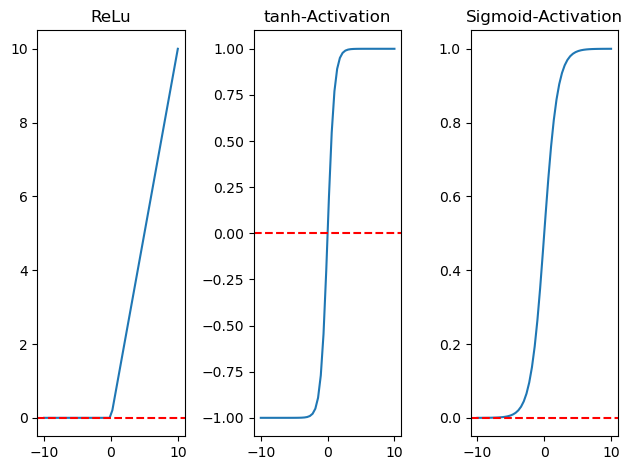

In [3]:
%matplotlib inline
x = np.linspace(-10,10)
fig,ax = plt.subplots(1,3,sharex=True,sharey=False)
ax[0].plot(x,relu(x))
ax[0].set_title("ReLu")

ax[1].plot(x,tanh(x))

ax[1].set_title("tanh-Activation")
ax[2].plot(x,sigmoid(x))

ax[2].set_title("Sigmoid-Activation")
for a in ax:
  a.axhline(0,color = "red",linestyle = "--")
plt.tight_layout()

## Derivatives of activation functions

In [4]:
def sigmoid_prime(x):
  s = sigmoid(x)
  
  return ( s*(1-s))

def relu_prime(x):
  r_p = np.ones_like(x)
  r_p[x<0] = 0
  return r_p

def tanh_prime(x):
  return ((1 - np.tanh(x)**2))



Now plot the same graphs from above but with derivatives....

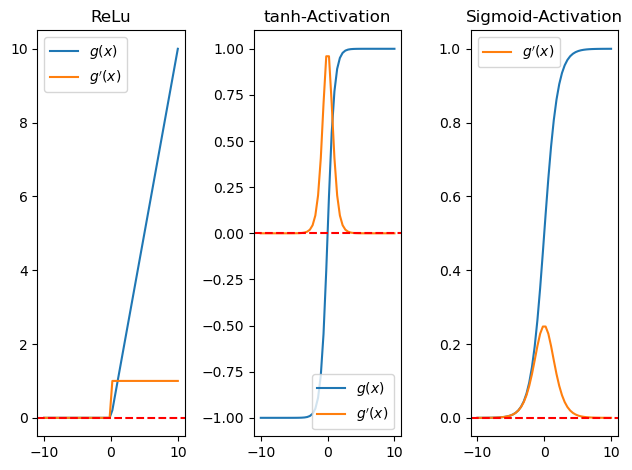

In [5]:
%matplotlib inline
x = np.linspace(-10,10)
fig,ax = plt.subplots(1,3,sharex=True,sharey=False)
ax[0].plot(x,relu(x),label = "$g(x)$")
ax[0].plot(x,relu_prime(x),label = "$g^\prime(x)$")
ax[0].legend()

ax[0].set_title("ReLu")

ax[1].plot(x,tanh(x),label = "$g(x)$")
ax[1].plot(x,tanh_prime(x),label = "$g^\prime(x)$")
ax[1].set_title("tanh-Activation")
ax[1].legend()

ax[2].plot(x,sigmoid(x))
ax[2].plot(x,sigmoid_prime(x),label = "$g^\prime(x)$")
ax[2].legend()


ax[2].set_title("Sigmoid-Activation")
for a in ax:
  a.axhline(0,color = "red",linestyle = "--")
plt.tight_layout()

First, we create a layer class. The $\textit{DenseLayer}$ - Class stands for a densely connected layer. It needs the number of neurons and an activation function. 

In [6]:
class DenseLayer():
    def __init__(self,n_neurons = 10,activation = "ReLu"):
        self.n_neurons = n_neurons
        self.parameters = dict({}) #Each layer has parameters W,b,a_prev, dW,db,dA, will be initiated during the compile() method
        self.activation = activation       
        
        self.assign_activation() #Assign forward and backward activation function...       

        
    def assign_activation(self):
        if self.activation.upper() == "RELU":
          self.act = relu
          self.backward_activation = self.relu_backward
          
          
        elif self.activation.upper() == "SIGMOID":
          self.act = sigmoid
          self.backward_activation = self.sigmoid_backward
        elif self.activation.upper() == "TANH":
          self.act = tanh
          self.backward_activation = self.tanh_backward
          
        else:
          self.act = linear
          self.backward_activation = self.lin_back
          
             
    def forward(self,x,training = False):
      """
      Simple forward pass through the model 
      
      returns: Activation 
      """
      Z = self.parameters["W"]@x + self.parameters["b"]


      A =  self.act(Z)    
      #Store variables in parameters (used for gradient descent) (Only during trianing)
      if training:
        self.parameters["Z"] = Z #output of the linear unit of the layer
        self.parameters["a"] = A #output of the layer with activation
        self.parameters["a_prev"] = x #what was the input to the layer
      return A


    def linear_backward(self,dZ):
        """
        backpropagation of the linear unit of the dense layer

        inputs: dZ (Gradients of the cost with respect to Z.)
        """
        A, W, b = self.parameters["a_prev"], self.parameters["W"], self.parameters["b"]

        m = A.shape[1]

        dW = 1/m * dZ@A.T
        db = np.sum(dZ,axis = 1,keepdims = True)
        dA_prev = W.T@dZ

        self.parameters["dW"] = dW
        self.parameters["db"] = db
        self.parameters["dA"] = dA_prev    
      
    def update_parameters(self, learning_rate = 1e-4):
      """
      Function to update the given parameters in the given layer by self.learning_rate
      """
      self.parameters["W"] = self.parameters["W"] - self.parameters["dW"]*learning_rate
      self.parameters["b"] = self.parameters["b"] - self.parameters["db"]*learning_rate
      
    def sigmoid_backward(self,dA):
        """
        backward propagation for a single SIGMOID unit.

        Arguments:
        dA -- post-activation gradient, of any shape

        Returns:
        dZ -- Gradient of the cost with respect to Z
        """
        Z = self.parameters["Z"]
        dZ = dA * sigmoid_prime(Z)
        return dZ

    def relu_backward(self,dA):
        """
        backward propagation for a single RELU unit.

        Arguments:
        dA -- post-activation gradient, of any shape

        Returns:
        dZ -- Gradient of the cost with respect to Z
        """

        #derivative of relu is always 1 (except at z < 0)
        Z = self.parameters["Z"]    
        dZ = dA * relu_prime(Z)
        return dZ


    def tanh_backward(self,dA):
        """
        backward propagation for a single TANH unit.

        Arguments:
        dA -- post-activation gradient, of any shape

        Returns:
        dZ -- Gradient of the cost with respect to Z
        """

        Z = self.parameters["Z"]

        dZ = dA * tanh_prime(Z)
        return dZ


    def lin_back(self,dA):
        Z = self.parameters["Z"]
        dZ = dA * 1

        return dZ


      



The neural network is formulated as a class. The NN-Class holds a list of layers that can be added. For this, the function self.add_layer(layer) is created.


## Forward pass

Each node is calculating the output of the linear unit ($Z$) using the following equation:
$$
\begin{equation}
Z =W^{T}\cdot X+b
\label{eq:ForwardPass}\tag{3}
\end{equation}
$$

The output of the linear unit is then activated using the activation function $\sigma(Z)$ to output $A$.

Thus, the forward pass through the network has the following shape:
$$
W,b \xrightarrow[unit]{linear}Z \xrightarrow[\sigma]{activation} A
$$


## Cost & Loss function
Since the chosen model is a classification problem with a total of 10 classes, cross-entropy is used as a loss function. 

The loss for one sample is calculated as follows: 
$$
\mathcal{L}(y,a) =  -\left(y * \log(a + (1 - y) \cdot \log(1-a) \right)
\label{eq:Loss}\tag{4}
$$
with: 
$y$ as the True values$\newline$
and$\newline$
$\hat{y}$ as the predicted values also referred to $a$

Summed over the total batch of data, the cost function yields equation $\ref{eq:costFunc}$.
$$
\begin{equation}
\begin{aligned}
J &= -\frac{1}{m}\sum_{i=1}^{m}\mathcal{L}_i\\
& = -\frac{1}{m}\sum_{i=1}^{m}\left(y^{(i)}\cdot \log(a^{[L](i)}) + ( 1- y^{(i)}) \cdot \log(1-a^{[L](i)})\right)
\end{aligned}
\label{eq:costFunc}\tag{5} 
\end{equation}
$$ 


## Backward propagation (Gradient descent)

As for the forward pass in the model, we need to calculate the backward path to perform gradient descent. Therefore we have to calculate the partial derivative of the cost function $\mathcal{J}$ with respect to each input variables $W$ and $b$ for each layer $l$.
Thus in order to update the weights the partial derivatives of the cost function $\mathcal{J}$ are needed:

* $\frac{\partial \mathcal{J}}{\partial W_l}$
* $\frac{\partial \mathcal{J}}{\partial b_l}$


But it has to be considered that the general direction of backpropagation has the form
$$
A \rightarrow Z \rightarrow W,b
$$

As for calculating the gradients for $W$ and $b$, the gradients of all the intermediate steps have to be consierded as well. With the help of the chain rule, the propagation of gradients is possible.


### Update Parameters
Having calculated the parameters $dW$ and $db$, the 
For each layer $[l]$ the parameters of the layer are updated as follows with the learning rate $\alpha$ .

$$ W^{[l]} = W^{[l]} - \alpha \cdot dW^{[l]}\tag{6}$$
$$ b^{[l]} = b^{[l]} - \alpha \cdot db^{[l]}\tag{7} $$

where $\alpha$ is the learning rate. 







### Derivative of cost function
The derivative of the cost function $\mathcal{J}(a,y)$  is defined as 

$$
\begin{equation}
\begin{aligned}
\frac{\partial \mathcal{J}(a,y)}{\partial a} &= da\\
&= \frac{d}{da}\left(-y\cdot\log(a) - (1-y) \cdot \log(1-a)\right)\\
& =-\frac{y}{a} + \frac{1-y}{1-a}
\end{aligned}
\label{eq:DerivativeCost}\tag{8}
\end{equation}
$$
With $a$ as the output of the last layer.

This $da$ derviative serves as the basis for the back propagation. 


### Derivative of the linear unit $dZ$

The partial derivative of the loss $\mathcal{J}(a,y)$  function with respect to $z$ can be formulated according the chain rule as follows:

$$
\begin{equation}
\frac{\partial \mathcal{J}(a,y)}{\partial z} = \frac{\partial \mathcal{J}(a,y)}{\partial a} \cdot \frac{\partial a}{\partial z}
\label{eq:DerivativeLinear}\tag{9}
\end{equation}
$$

while  $\frac{\partial a}{\partial z}$ is the derivative of the activation function with respect to the output of the linear unit $z$ and thus:


$$
\begin{equation}
\frac{d}{dz} g(z)=  g^\prime(z)
\label{eq:DerivativeChain}\tag{10}
\end{equation}
$$

and thus combing equation $\ref{eq:DerivativeLinear}$

$$
\begin{equation}
dz = da \cdot g^\prime(z)
\label{eq:DerChain2}\tag{11}
\end{equation}
$$


returning the gradients of the linear unit Z $dz$. 






### Derivative of parameters $W$ and $b$ with respect to the cost function $\mathcal{J}$
Applied to the vectorized version of the neural network, all the updates $dW$ and $db$ have to be scaled according the sample number $m$.

The linear unit for the layer with index $l$ has the form
$$
\begin{equation}
Z^{l} = W^{l}\cdot A^{[l-1]} + b^{l}
\label{eq:LinearUnit}\tag{12}
\end{equation}
$$

to calculate the respective gradients of this function, the partial derivatives $\frac{Z}{\partial W}$ and $\frac{Z}{\partial b}$ have to be calculated:

Thus, the partial derivatives of equation $\ref{eq:LinearUnit}$ have the form:
$$
\begin{equation}
\begin{aligned}
\frac{\partial Z^{l}}{\partial W^{l}}&  = A^{[l-1]}\\
\frac{\partial Z^{l}}{\partial b^{l}}& =  1
\end{aligned}
\end{equation}
$$

After the application of the chain rule it follows that 



$$ dW^{[l]} = \frac{\partial \mathcal{J}(W,b) }{\partial W^{[l]}} = \frac{\partial \mathcal{J}(a,y)}{\partial a} \cdot \frac{\partial a}{\partial z}\cdot \frac{\partial z}{\partial W}= \frac{1}{m} dZ^{[l]} A^{[l-1]^{T}} \tag{13}$$
$$ db^{[l]} = \frac{\partial \mathcal{J}(W,b) }{\partial b^{[l]}} \cdot \frac{\partial a}{\partial z}\cdot \frac{\partial z}{\partial b} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}\tag{14}$$

To further backpropagate in the network the next partial derivative of the activation function is calculated as follows:
$$ dA^{[l-1]} = \frac{\partial \mathcal{J} }{\partial A^{[l-1]}} = W^{[l]^{T}} dZ^{[l]} \tag{14}$$




In [7]:
class NN():
    cache = dict({})
    #layers = []
    total_parms = 0
    def __init__(self,input_size = (1,1),
                 learning_rate = 0.01):
        self.input_size = input_size
        self.input_n = np.product(self.input_size)
        self.learning_rate = learning_rate
        self.layers = []
        self.parameters = dict()
        self.trained = False
        
    def add_layer(self,L):
        self.layers.append(L)
        self.model_compiled = False


    def compile_model(self):
        prev_N = self.input_n
        for _i, layer in enumerate(self.layers):
            #assign name
            layer.name = layer.activation + "_" + str(_i+1)

            #each layer has the dimension of (hidden_neurons x hidden_neurons_prev.Layer)
            layer.parameters["W"] = np.random.randn(layer.n_neurons, prev_N) *0.01
            layer.parameters["b"] = np.zeros((layer.n_neurons, 1))
            layer.parameters["a"] = np.zeros((layer.n_neurons, 1))

            layer.n_params = int(np.product(layer.parameters["W"].shape) + np.product(layer.parameters["b"]))

            self.total_parms += layer.n_params

            print(30*"*")
            print("Layer: {:d}".format(_i+1) + ": Activation", layer.activation)
            print("W's shape:", layer.parameters["W"].shape)
            print("b's shape:", layer.parameters["b"].shape)
            print("Layers' parameters:", layer.n_params)
            print("")
            prev_N = layer.n_neurons

        print("Total Params: {:d}".format(self.total_parms))
        self.model_compiled = True


    def predict(self,x):
      """
      input-arguments: Array of input features
      returns: prediction array
      """
      preds = self.forward_pass(x,training=False)
      return preds
      
      
      
    def forward_pass(self,x,training = True):

        if not self.model_compiled:
            raise BaseException("Please compile model first!")

        x_new = x
        #pass all the inputs directly through all the Layers
        for _i,layer in enumerate(self.layers):
            #pass it through the layers....
            a = layer.forward(x_new,training = training)
            x_new = a #store new actvitaion as x_new, to pass on in next layer....
        return x_new


    def compute_cost(self, y, y_hat):
        m = y.shape[1]
        
        cost = -1 / m * np.sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
        cost = np.squeeze(cost) 

#         print("Cost:",cost)
        return cost


    def backward_step(self,Y):
        """
        Implementation of a backward calculation step

        """

        #Derviative of cost function with respect to A (for the last layer)
        dAL = - (np.divide(Y, self.layers[-1].parameters["a"]) -
                 np.divide(1 - Y, 1 - self.layers[-1].parameters["a"]))

        dZ = self.layers[-1].backward_activation(dAL)
        self.layers[-1].linear_backward(dZ)
        #self.activation_backward(dAL,self.layers[-1])
        self.layers[-1].update_parameters(learning_rate = self.learning_rate)


        prevLayer = self.layers[-1]
        #walk backwards through the layers....
        for _i,layer in enumerate(reversed(self.layers[:-1])):
            #print(_i,layer.activation)
            dA_prev= prevLayer.parameters["dA"]
            
            dZ = layer.backward_activation(dA_prev)
            layer.linear_backward(dZ)
#             self.activation_backward(dA_prev, layer)
            layer.update_parameters(learning_rate = self.learning_rate)
            prevLayer = layer
            
            

    def fit(self,
            X_train,
            Y_train,
            X_test,
            Y_test,
            n_epochs = 50,
            plot_res = True):
        # do forward pass
        x_new = self.forward_pass(X_train.T,training=True)

        self.compute_cost(Y_train,x_new)
#         self.Y = Y_train


        self.train_ = []

        for i in range(n_epochs):
            print("Epoch:", i, 30 * "*")
            self.backward_step(Y_train)
            x_new = self.forward_pass(X_train.T)
            self.train_loss = self.compute_cost(Y_train,x_new)
            self.train_acc = accuracy_score(np.argmax(x_new, axis=0),
                                 np.argmax(
                                   Y_train.T, 1))

            # now test....
            preds = self.predict(X_test.T)
            self.test_loss = self.compute_cost(Y_test,preds)
            self.test_acc = accuracy_score(np.argmax(preds, axis=0),
                                 np.argmax(Y_test.T, 1))

            self.train_.append([i, 
                                self.train_loss, 
                                self.train_acc,
                                self.test_loss,
                                self.test_acc])
            
            
            print("Train Accuracy: {:.1f}%".format(self.train_acc * 100.))
            print("Test Accuracy: {:.1f}%".format(self.test_acc * 100.))
            print("Train Loss: {:.1f}".format(self.train_loss))
            print("Test Loss: {:.1f}".format(self.test_loss ))



        self.trained = True
        
        if plot_res:
          self.plot_training()

         
    def save(self,path):
        with open(path, 'wb') as f:
            pickle.dump(self, f)
            

    def plot_training(self):
      fig,ax = plt.subplots(1)
      ax.plot(
          np.array(self.train_)[:, 0],
          np.array(self.train_)[:, 2]*100.,label = "Training Accuracy"
      )
                                     
      ax.plot(
          np.array(self.train_)[:, 0],
          np.array(self.train_)[:, 4]*100.,label = "Test Accuracy"
      )
      ax.set_ylabel("Accuracy [%]")
      ax.set_ylim([0., 100])
      
                               
      ax2 = ax.twinx()
      ax2.plot(
          np.array(self.train_)[:, 0],
          np.array(self.train_)[:, 1],label = "Training Loss",linestyle = "--"
      )
      
      ax2.plot(
          np.array(self.train_)[:, 0],
          np.array(self.train_)[:, 3],label = "Test Loss",linestyle = "--"
      )
      ax2.set_ylabel("Loss []")

      ax2.legend()
      
      




            
            


Load the data. 
The data is taken from https://www.kaggle.com/datasets/zalando-research/fashionmnist, downloaded and saved as as csv-file.

In [8]:

def load_data():
    train_data = np.loadtxt(r"data/fashion-mnist_train.csv", delimiter=",",skiprows=1)
    Y_train = train_data[:,0]
    X_train = train_data[:,1:]

    test_data = np.loadtxt(r"data/fashion-mnist_test.csv", delimiter=",",skiprows=1)
    Y_test = test_data[:,0]
    X_test = test_data[:,1:]

    # data_train = pd.read_csv(r"data\fashion-mnist_train.csv", nrows=100000000)
    # data_test = pd.read_csv(r"data\fashion-mnist_test.csv")
    # ylabs_train = data_train.pop("label")
    # ylabs_test = data_test.pop("label")
    encoder = OneHotEncoder(sparse=False)
    Y_train_enc = encoder.fit_transform(Y_train.reshape(-1, 1)).T
    Y_test_enc = encoder.transform(Y_test.reshape(-1, 1)).T

    return X_train,Y_train_enc,X_test,Y_test_enc,encoder


In [9]:
data_train,Y_train,data_test,Y_test,enc = load_data()

In [10]:
class_names = ["T-shirt/top" , 
               "Trouser",
               "Pullover",
               "Dress",
               "Coat",
               "Sandal",
               "Shirt",
               "Sneaker",
               "Bag",
               "Ankle boot"]


Define the network

In [11]:
myNetwork = NN(input_size = (28,28),
                 learning_rate = 1e-4)

Layer1 = DenseLayer(n_neurons=200)
Layer2 = DenseLayer(n_neurons=200)
Layer3 = DenseLayer(n_neurons=10,activation="sigmoid")

myNetwork.add_layer(Layer1)
myNetwork.add_layer(Layer2)
myNetwork.add_layer(Layer3)
myNetwork.compile_model()


******************************
Layer: 1: Activation ReLu
W's shape: (200, 784)
b's shape: (200, 1)
Layers' parameters: 156800

******************************
Layer: 2: Activation ReLu
W's shape: (200, 200)
b's shape: (200, 1)
Layers' parameters: 40000

******************************
Layer: 3: Activation sigmoid
W's shape: (10, 200)
b's shape: (10, 1)
Layers' parameters: 2000

Total Params: 198800


Epoch: 0 ******************************
Train Accuracy: 9.6%
Test Accuracy: 9.5%
Train Loss: 3.3
Test Loss: 3.3
Epoch: 1 ******************************
Train Accuracy: 12.2%
Test Accuracy: 12.4%
Train Loss: 3.3
Test Loss: 3.3
Epoch: 2 ******************************
Train Accuracy: 14.1%
Test Accuracy: 14.2%
Train Loss: 3.2
Test Loss: 3.2
Epoch: 3 ******************************
Train Accuracy: 15.3%
Test Accuracy: 15.1%
Train Loss: 3.2
Test Loss: 3.2
Epoch: 4 ******************************
Train Accuracy: 16.2%
Test Accuracy: 16.0%
Train Loss: 3.2
Test Loss: 3.2
Epoch: 5 ******************************
Train Accuracy: 16.9%
Test Accuracy: 16.7%
Train Loss: 3.2
Test Loss: 3.2
Epoch: 6 ******************************
Train Accuracy: 17.6%
Test Accuracy: 17.2%
Train Loss: 3.2
Test Loss: 3.2
Epoch: 7 ******************************
Train Accuracy: 18.1%
Test Accuracy: 17.6%
Train Loss: 3.2
Test Loss: 3.2
Epoch: 8 ******************************
Train Accuracy: 18.7%
Test Accuracy: 18.3%
Train L

Train Accuracy: 40.4%
Test Accuracy: 40.5%
Train Loss: 3.0
Test Loss: 3.0
Epoch: 72 ******************************
Train Accuracy: 40.6%
Test Accuracy: 40.6%
Train Loss: 3.0
Test Loss: 3.0
Epoch: 73 ******************************
Train Accuracy: 40.8%
Test Accuracy: 40.9%
Train Loss: 3.0
Test Loss: 3.0
Epoch: 74 ******************************
Train Accuracy: 41.1%
Test Accuracy: 41.1%
Train Loss: 3.0
Test Loss: 3.0
Epoch: 75 ******************************
Train Accuracy: 41.3%
Test Accuracy: 41.3%
Train Loss: 3.0
Test Loss: 3.0
Epoch: 76 ******************************
Train Accuracy: 41.5%
Test Accuracy: 41.5%
Train Loss: 3.0
Test Loss: 3.0
Epoch: 77 ******************************
Train Accuracy: 41.7%
Test Accuracy: 41.7%
Train Loss: 3.0
Test Loss: 3.0
Epoch: 78 ******************************
Train Accuracy: 41.9%
Test Accuracy: 41.9%
Train Loss: 3.0
Test Loss: 3.0
Epoch: 79 ******************************
Train Accuracy: 42.1%
Test Accuracy: 42.1%
Train Loss: 3.0
Test Loss: 3.0
Epoch:

Train Accuracy: 53.9%
Test Accuracy: 54.2%
Train Loss: 2.7
Test Loss: 2.7
Epoch: 143 ******************************
Train Accuracy: 54.0%
Test Accuracy: 54.3%
Train Loss: 2.7
Test Loss: 2.7
Epoch: 144 ******************************
Train Accuracy: 54.2%
Test Accuracy: 54.4%
Train Loss: 2.7
Test Loss: 2.7
Epoch: 145 ******************************
Train Accuracy: 54.3%
Test Accuracy: 54.5%
Train Loss: 2.7
Test Loss: 2.7
Epoch: 146 ******************************
Train Accuracy: 54.5%
Test Accuracy: 54.6%
Train Loss: 2.7
Test Loss: 2.7
Epoch: 147 ******************************
Train Accuracy: 54.6%
Test Accuracy: 54.8%
Train Loss: 2.7
Test Loss: 2.7
Epoch: 148 ******************************
Train Accuracy: 54.7%
Test Accuracy: 54.9%
Train Loss: 2.7
Test Loss: 2.7
Epoch: 149 ******************************
Train Accuracy: 54.9%
Test Accuracy: 54.9%
Train Loss: 2.7
Test Loss: 2.7
Epoch: 150 ******************************
Train Accuracy: 55.0%
Test Accuracy: 55.0%
Train Loss: 2.7
Test Loss: 2.

Train Accuracy: 60.6%
Test Accuracy: 60.6%
Train Loss: 2.5
Test Loss: 2.5
Epoch: 214 ******************************
Train Accuracy: 60.7%
Test Accuracy: 60.6%
Train Loss: 2.5
Test Loss: 2.5
Epoch: 215 ******************************
Train Accuracy: 60.7%
Test Accuracy: 60.7%
Train Loss: 2.5
Test Loss: 2.5
Epoch: 216 ******************************
Train Accuracy: 60.8%
Test Accuracy: 60.8%
Train Loss: 2.5
Test Loss: 2.5
Epoch: 217 ******************************
Train Accuracy: 60.9%
Test Accuracy: 60.8%
Train Loss: 2.5
Test Loss: 2.5
Epoch: 218 ******************************
Train Accuracy: 61.0%
Test Accuracy: 60.9%
Train Loss: 2.5
Test Loss: 2.5
Epoch: 219 ******************************
Train Accuracy: 61.0%
Test Accuracy: 61.0%
Train Loss: 2.5
Test Loss: 2.5
Epoch: 220 ******************************
Train Accuracy: 61.1%
Test Accuracy: 61.0%
Train Loss: 2.5
Test Loss: 2.5
Epoch: 221 ******************************
Train Accuracy: 61.1%
Test Accuracy: 61.1%
Train Loss: 2.5
Test Loss: 2.

Train Accuracy: 64.2%
Test Accuracy: 63.9%
Train Loss: 2.3
Test Loss: 2.3
Epoch: 285 ******************************
Train Accuracy: 64.3%
Test Accuracy: 64.0%
Train Loss: 2.3
Test Loss: 2.3
Epoch: 286 ******************************
Train Accuracy: 64.3%
Test Accuracy: 64.0%
Train Loss: 2.3
Test Loss: 2.3
Epoch: 287 ******************************
Train Accuracy: 64.4%
Test Accuracy: 64.1%
Train Loss: 2.3
Test Loss: 2.3
Epoch: 288 ******************************
Train Accuracy: 64.4%
Test Accuracy: 64.1%
Train Loss: 2.3
Test Loss: 2.3
Epoch: 289 ******************************
Train Accuracy: 64.4%
Test Accuracy: 64.1%
Train Loss: 2.3
Test Loss: 2.3
Epoch: 290 ******************************
Train Accuracy: 64.5%
Test Accuracy: 64.2%
Train Loss: 2.3
Test Loss: 2.3
Epoch: 291 ******************************
Train Accuracy: 64.5%
Test Accuracy: 64.3%
Train Loss: 2.3
Test Loss: 2.3
Epoch: 292 ******************************
Train Accuracy: 64.5%
Test Accuracy: 64.3%
Train Loss: 2.3
Test Loss: 2.

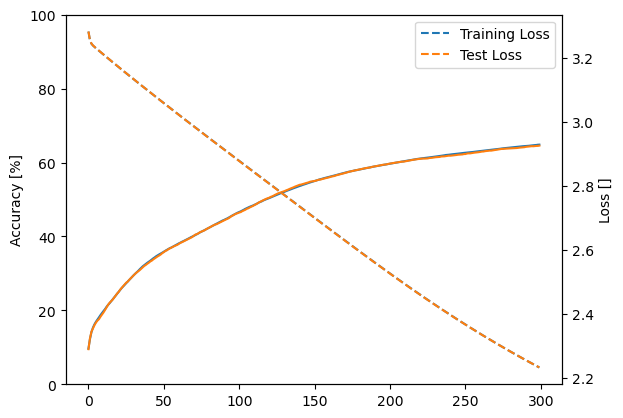

In [12]:
%matplotlib inline
myNetwork.fit(X_train=data_train,
                  Y_train = Y_train,
                  X_test = data_test,
                  Y_test = Y_test,
                  plot_res=True,
              n_epochs = 300
             )
myNetwork.save("myNetwork_300")

# Application of the network

In [13]:
preds = myNetwork.predict(data_test.T).T

In [14]:
acc = accuracy_score( np.argmax(Y_test.T, 1),np.argmax(preds, axis=1))


In [15]:
conf_mat = confusion_matrix(np.argmax(Y_test, axis=0), np.argmax(preds.T, axis=0), normalize="pred",
                  
                           )

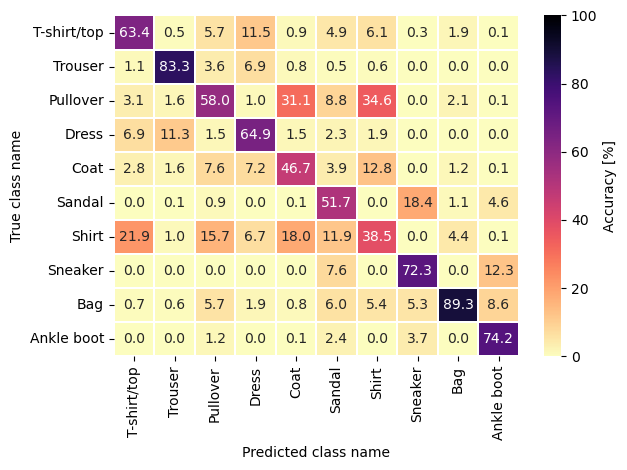

In [19]:
fig, ax = plt.subplots(1)
sns.heatmap(conf_mat * 100., 
            xticklabels=class_names, 
            yticklabels=class_names, 
            annot=True, 
            fmt=".1f", vmin=0,
            vmax=100,
            cmap = "magma_r",
            linecolor = "white",linewidth = .2,
               cbar_kws={'label': 'Accuracy [%]'})
ax.set_xlabel("Predicted class name")
ax.set_ylabel("True class name")
plt.tight_layout()
fig.savefig("Figures/PredictionAccuracyLoss.svg")

From the above confusion matrix, we can see that certain classes are very well predicted. For instance the Trouser Class is very well separted with an accuracy score of over 90%. Same goes for the ankle boots.
The neural network has still some problems with classes that are close together. For instance the Shirt class is correctly predicted only with a probability of 41 %. It messes up with all kinds of other classes that resemble the shirt class. 

## Plot predicted results

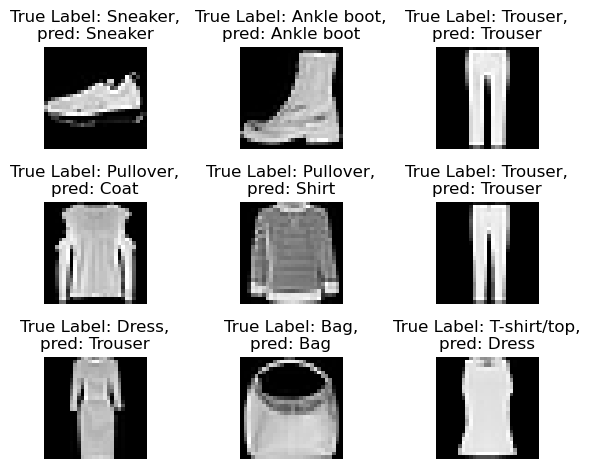

In [18]:
  idx_rnd = np.random.choice(range(Y_test.shape[1]), 9)
  fig, axs = plt.subplots(3, 3)
  ax_fl = axs.flatten()
  for i in range(9):
      ax_fl[i].imshow(data_test[idx_rnd[i]].reshape(28, 28),
                      cmap = "gray")
      true_label = class_names[int(enc.inverse_transform(Y_test[:,idx_rnd[i]].reshape(1,-1))[0][0])]
      pred_label = class_names[np.argmax(preds[idx_rnd[i],:])]

      ax_fl[i].set_title("True Label: {},\npred: {}".format(true_label,pred_label))
      ax_fl[i].axis("off")
  plt.tight_layout()
  fig.savefig("Figures/Predictions.svg")
  plt.show()

